In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm
import sys
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
batch_size = 32
image_size = 32
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])

trainval = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainval, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(f"Size of trainval: {len(trainval)}")
print(f"Size of trainset: {len(trainset)}")
print(f"Size of valset: {len(valset)}")
print(f"Size of testset: {len(testset)}")
for images, labels in trainloader:
    print("Image batch dimensions:", images.size())
    print("Label batch dimensions:", labels.size())
    break # Print only for the first batch

Size of trainval: 50000
Size of trainset: 45000
Size of valset: 5000
Size of testset: 10000
Image batch dimensions: torch.Size([32, 3, 32, 32])
Label batch dimensions: torch.Size([32])


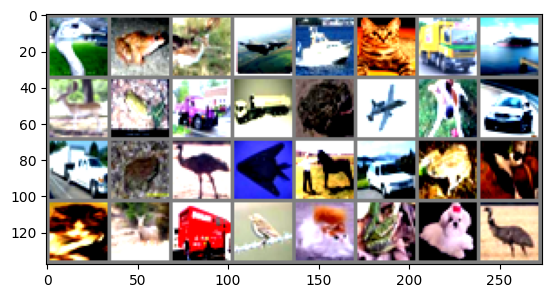

 bird  frog  deer plane  ship   cat truck  ship


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
# Use next(dataiter) instead of dataiter.next()
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
torch.cuda.is_available()

True

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def init_weights_xavier(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.constant_(m.bias, 0)

net.apply(init_weights_xavier)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epoch_num = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(epoch_num):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    current_lr = optimizer.param_groups[0]['lr']

    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss/ len(valloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{epoch_num}, '
          f'Learning Rate: {current_lr:.1e}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Epoch 1/10, Learning Rate: 1.0e-03, Train Loss: 1.7668, Train Accuracy: 35.60%, Validation Loss: 1.5296, Validation Accuracy: 43.86%
Epoch 2/10, Learning Rate: 1.0e-03, Train Loss: 1.4360, Train Accuracy: 48.12%, Validation Loss: 1.3577, Validation Accuracy: 51.04%
Epoch 3/10, Learning Rate: 1.0e-03, Train Loss: 1.3269, Train Accuracy: 52.45%, Validation Loss: 1.2985, Validation Accuracy: 54.50%
Epoch 4/10, Learning Rate: 1.0e-03, Train Loss: 1.2568, Train Accuracy: 55.08%, Validation Loss: 1.2636, Validation Accuracy: 55.18%
Epoch 5/10, Learning Rate: 1.0e-03, Train Loss: 1.2017, Train Accuracy: 57.45%, Validation Loss: 1.2095, Validation Accuracy: 56.42%
Epoch 6/10, Learning Rate: 1.0e-03, Train Loss: 1.1561, Train Accuracy: 59.09%, Validation Loss: 1.1682, Validation Accuracy: 58.44%
Epoch 7/10, Learning Rate: 1.0e-03, Train Loss: 1.1070, Train Accuracy: 60.97%, Validation Loss: 1.1359, Validation Accuracy: 59.70%
Epoch 8/10, Learning Rate: 1.0e-03, Train Loss: 1.0762, Train Accurac

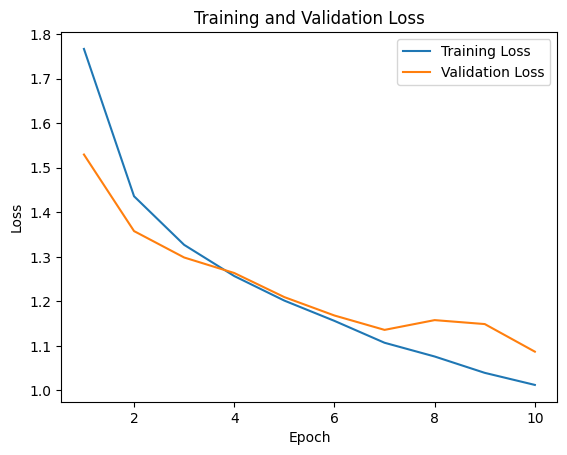

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

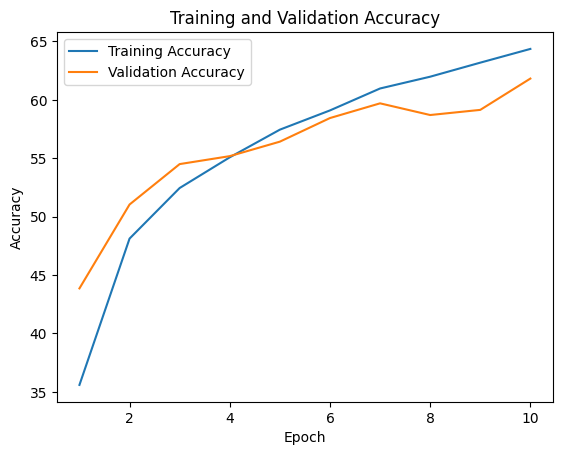

In [ ]:
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

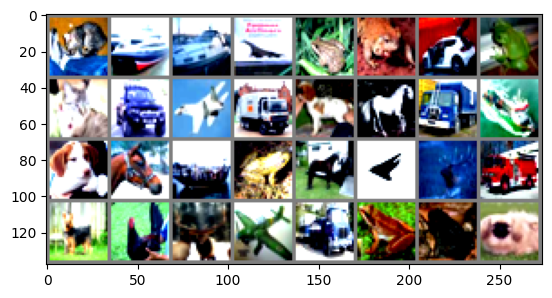

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<ipython-input-14-8b61435874a9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 75 %
Accuracy of  bird : 46 %
Accuracy of   cat : 47 %
Accuracy of  deer : 46 %
Accuracy of   dog : 45 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 76 %
Accuracy of truck : 63 %


In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)

num_classes = len(classes)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 118MB/s]


In [ ]:

epoch_num = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(epoch_num):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    vgg16.train()
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epoch_num} - Training")):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Validation loop
    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Epoch {epoch+1}/{epoch_num} - Validation"):
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs = vgg16(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

    val_loss = val_loss/ len(valloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{epoch_num}, '
          f'Learning Rate: {current_lr:.1e}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')


Epoch 1/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10, Learning Rate: 1.0e-03, Train Loss: 0.9365, Train Accuracy: 67.49%, Validation Loss: 0.6442, Validation Accuracy: 78.16%


Epoch 2/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Learning Rate: 1.0e-03, Train Loss: 0.5923, Train Accuracy: 79.69%, Validation Loss: 0.6188, Validation Accuracy: 78.72%


Epoch 3/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Learning Rate: 1.0e-03, Train Loss: 0.4880, Train Accuracy: 83.18%, Validation Loss: 0.5143, Validation Accuracy: 81.72%


Epoch 4/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Learning Rate: 1.0e-03, Train Loss: 0.4179, Train Accuracy: 85.60%, Validation Loss: 0.4793, Validation Accuracy: 83.62%


Epoch 5/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Learning Rate: 1.0e-03, Train Loss: 0.3603, Train Accuracy: 87.64%, Validation Loss: 0.4754, Validation Accuracy: 84.20%


Epoch 6/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Learning Rate: 1.0e-03, Train Loss: 0.3154, Train Accuracy: 89.14%, Validation Loss: 0.4472, Validation Accuracy: 85.08%


Epoch 7/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10, Learning Rate: 1.0e-03, Train Loss: 0.2727, Train Accuracy: 90.67%, Validation Loss: 0.4530, Validation Accuracy: 85.20%


Epoch 8/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10, Learning Rate: 1.0e-03, Train Loss: 0.2366, Train Accuracy: 91.89%, Validation Loss: 0.5005, Validation Accuracy: 83.56%


Epoch 9/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10, Learning Rate: 1.0e-03, Train Loss: 0.2020, Train Accuracy: 93.22%, Validation Loss: 0.4601, Validation Accuracy: 85.74%


Epoch 10/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10, Learning Rate: 1.0e-03, Train Loss: 0.1742, Train Accuracy: 94.08%, Validation Loss: 0.4745, Validation Accuracy: 85.72%
Finished Training


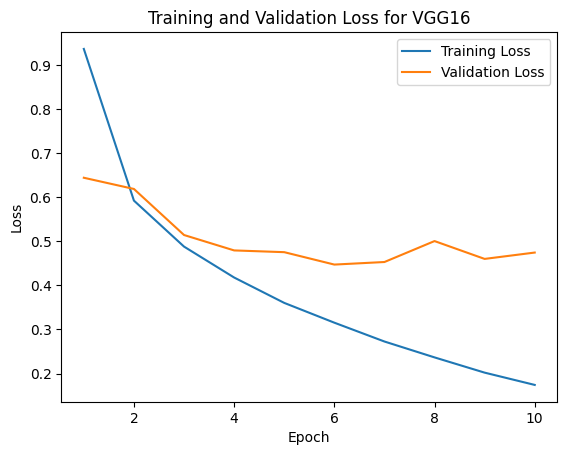

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.show()

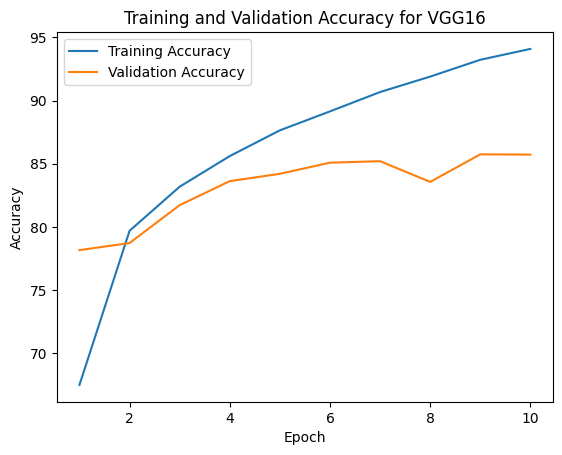

In [ ]:
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16')
plt.legend()
plt.show()

In [ ]:
PATH = './vgg16.pth'
torch.save(vgg16.state_dict(), PATH)

In [ ]:
vgg16.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct / total:.2f}%')

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.47%


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(images.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 94 %
Accuracy of  bird : 80 %
Accuracy of   cat : 66 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 95 %
Accuracy of truck : 91 %


In [ ]:
vgg19 = torchvision.models.vgg19(pretrained=True)
num_classes = len(classes)
vgg19.classifier[6] = nn.Linear(4096, num_classes)
vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg19.parameters(), lr=0.001)


epoch_num = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epoch_num):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    vgg19.train()
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epoch_num} - Training")):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    vgg19.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Epoch {epoch+1}/{epoch_num} - Validation"):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = vgg19(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss/ len(valloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{epoch_num}, '
          f'Learning Rate: {current_lr:.1e}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.1MB/s]


Epoch 1/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10, Learning Rate: 1.0e-03, Train Loss: 0.9182, Train Accuracy: 68.17%, Validation Loss: 0.6302, Validation Accuracy: 77.92%


Epoch 2/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Learning Rate: 1.0e-03, Train Loss: 0.5684, Train Accuracy: 80.40%, Validation Loss: 0.5376, Validation Accuracy: 81.56%


Epoch 3/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Learning Rate: 1.0e-03, Train Loss: 0.4678, Train Accuracy: 84.03%, Validation Loss: 0.4853, Validation Accuracy: 82.88%


Epoch 4/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Learning Rate: 1.0e-03, Train Loss: 0.3988, Train Accuracy: 86.33%, Validation Loss: 0.4537, Validation Accuracy: 84.04%


Epoch 5/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Learning Rate: 1.0e-03, Train Loss: 0.3465, Train Accuracy: 88.01%, Validation Loss: 0.4373, Validation Accuracy: 84.28%


Epoch 6/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Learning Rate: 1.0e-03, Train Loss: 0.3009, Train Accuracy: 89.56%, Validation Loss: 0.4537, Validation Accuracy: 84.58%


Epoch 7/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10, Learning Rate: 1.0e-03, Train Loss: 0.2651, Train Accuracy: 90.96%, Validation Loss: 0.4337, Validation Accuracy: 85.68%


Epoch 8/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10, Learning Rate: 1.0e-03, Train Loss: 0.2294, Train Accuracy: 92.14%, Validation Loss: 0.4347, Validation Accuracy: 85.92%


Epoch 9/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10, Learning Rate: 1.0e-03, Train Loss: 0.1998, Train Accuracy: 93.13%, Validation Loss: 0.4542, Validation Accuracy: 85.96%


Epoch 10/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10, Learning Rate: 1.0e-03, Train Loss: 0.1730, Train Accuracy: 94.09%, Validation Loss: 0.4897, Validation Accuracy: 85.74%
Finished Training


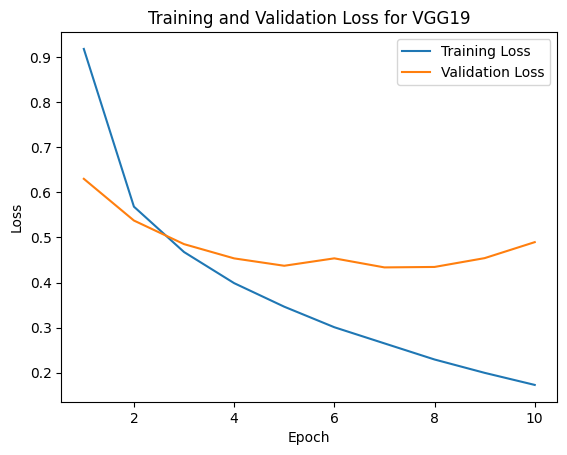

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG19')
plt.legend()
plt.show()

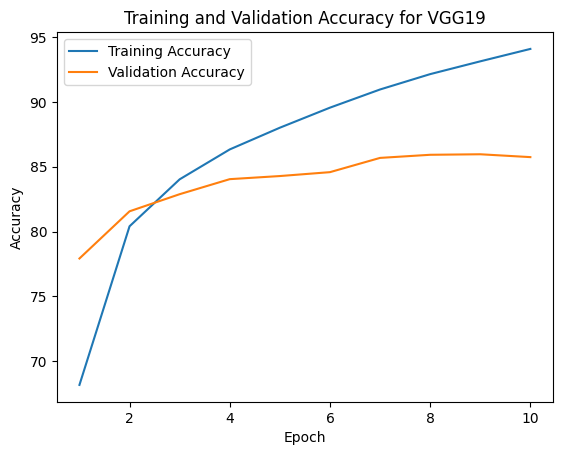

In [ ]:
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG19')
plt.legend()
plt.show()

In [ ]:
PATH = './vgg19.pth'
torch.save(vgg19.state_dict(), PATH)

In [ ]:
vgg19.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct / total:.2f}%')

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.99%


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(images.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 93 %
Accuracy of  bird : 81 %
Accuracy of   cat : 69 %
Accuracy of  deer : 89 %
Accuracy of   dog : 78 %
Accuracy of  frog : 91 %
Accuracy of horse : 84 %
Accuracy of  ship : 94 %
Accuracy of truck : 89 %


In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

resnet18 = resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

epoch_num = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epoch_num):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    resnet18.train()
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epoch_num} - Training")):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    resnet18.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Epoch {epoch+1}/{epoch_num} - Validation"):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{epoch_num}, '
          f'Learning Rate: {current_lr:.1e}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')


Epoch 1/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10, Learning Rate: 1.0e-03, Train Loss: 1.0423, Train Accuracy: 64.22%, Validation Loss: 0.7341, Validation Accuracy: 75.62%


Epoch 2/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Learning Rate: 1.0e-03, Train Loss: 0.6732, Train Accuracy: 76.96%, Validation Loss: 0.5949, Validation Accuracy: 79.24%


Epoch 3/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Learning Rate: 1.0e-03, Train Loss: 0.5232, Train Accuracy: 81.97%, Validation Loss: 0.5775, Validation Accuracy: 80.44%


Epoch 4/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Learning Rate: 1.0e-03, Train Loss: 0.4270, Train Accuracy: 85.18%, Validation Loss: 0.5794, Validation Accuracy: 81.08%


Epoch 5/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Learning Rate: 1.0e-03, Train Loss: 0.3487, Train Accuracy: 87.94%, Validation Loss: 0.6093, Validation Accuracy: 80.42%


Epoch 6/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Learning Rate: 1.0e-03, Train Loss: 0.2872, Train Accuracy: 89.81%, Validation Loss: 0.6279, Validation Accuracy: 80.26%


Epoch 7/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10, Learning Rate: 1.0e-03, Train Loss: 0.2387, Train Accuracy: 91.65%, Validation Loss: 0.6235, Validation Accuracy: 81.22%


Epoch 8/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10, Learning Rate: 1.0e-03, Train Loss: 0.2024, Train Accuracy: 92.91%, Validation Loss: 0.6507, Validation Accuracy: 81.22%


Epoch 9/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10, Learning Rate: 1.0e-03, Train Loss: 0.1720, Train Accuracy: 94.14%, Validation Loss: 0.6949, Validation Accuracy: 81.28%


Epoch 10/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10, Learning Rate: 1.0e-03, Train Loss: 0.1530, Train Accuracy: 94.64%, Validation Loss: 0.6987, Validation Accuracy: 81.26%
Finished Training


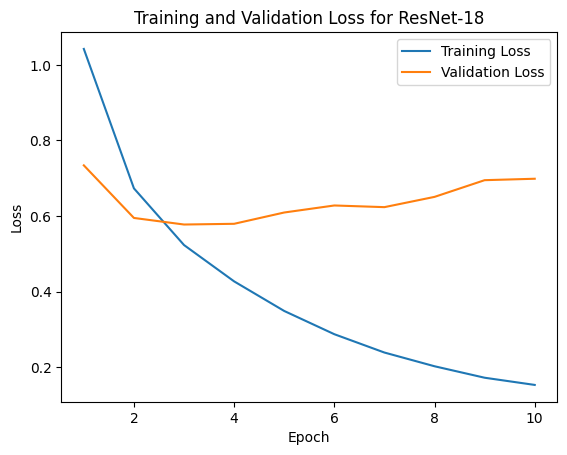

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet-18')
plt.legend()
plt.show()

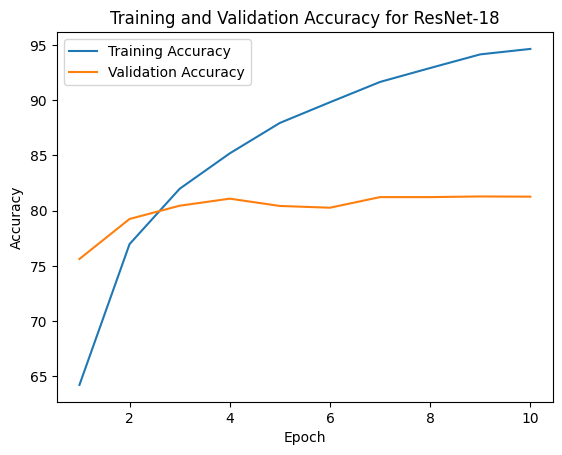

In [ ]:
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet-18')
plt.legend()
plt.show()

In [ ]:
PATH = './resnet18.pth'
torch.save(resnet18.state_dict(), PATH)

In [ ]:
resnet18.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct / total:.2f}%')

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81.45%


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(images.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 93 %
Accuracy of  bird : 81 %
Accuracy of   cat : 69 %
Accuracy of  deer : 89 %
Accuracy of   dog : 78 %
Accuracy of  frog : 91 %
Accuracy of horse : 84 %
Accuracy of  ship : 94 %
Accuracy of truck : 89 %


In [ ]:
resnet34 = models.resnet34(pretrained=True)

num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 10)

resnet34 = resnet34.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9)

epoch_num = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epoch_num):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    resnet34.train()
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epoch_num} - Training")):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    resnet34.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Epoch {epoch+1}/{epoch_num} - Validation"):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{epoch_num}, '
          f'Learning Rate: {current_lr:.1e}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 45.7MB/s]


Epoch 1/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10, Learning Rate: 1.0e-03, Train Loss: 0.9944, Train Accuracy: 65.53%, Validation Loss: 0.6779, Validation Accuracy: 76.50%


Epoch 2/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10, Learning Rate: 1.0e-03, Train Loss: 0.6066, Train Accuracy: 79.41%, Validation Loss: 0.5978, Validation Accuracy: 79.48%


Epoch 3/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10, Learning Rate: 1.0e-03, Train Loss: 0.4586, Train Accuracy: 84.20%, Validation Loss: 0.5512, Validation Accuracy: 81.34%


Epoch 4/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10, Learning Rate: 1.0e-03, Train Loss: 0.3615, Train Accuracy: 87.60%, Validation Loss: 0.5616, Validation Accuracy: 81.34%


Epoch 5/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10, Learning Rate: 1.0e-03, Train Loss: 0.2866, Train Accuracy: 90.08%, Validation Loss: 0.6579, Validation Accuracy: 80.68%


Epoch 6/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10, Learning Rate: 1.0e-03, Train Loss: 0.2330, Train Accuracy: 91.88%, Validation Loss: 0.6139, Validation Accuracy: 81.32%


Epoch 7/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10, Learning Rate: 1.0e-03, Train Loss: 0.1933, Train Accuracy: 93.40%, Validation Loss: 0.6247, Validation Accuracy: 81.20%


Epoch 8/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10, Learning Rate: 1.0e-03, Train Loss: 0.1593, Train Accuracy: 94.60%, Validation Loss: 0.6095, Validation Accuracy: 82.28%


Epoch 9/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10, Learning Rate: 1.0e-03, Train Loss: 0.1309, Train Accuracy: 95.59%, Validation Loss: 0.7052, Validation Accuracy: 81.28%


Epoch 10/10 - Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10, Learning Rate: 1.0e-03, Train Loss: 0.1072, Train Accuracy: 96.38%, Validation Loss: 0.6562, Validation Accuracy: 83.02%
Finished Training
